<a href="https://colab.research.google.com/github/fourmodern/targetdiscovery/blob/main/04_nsclc_llm_coscientist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🤖 LLM Co-scientist를 활용한 NSCLC 표적 후보 검증 및 평가

---

## 📚 Aim of this Tutorial

본 튜토리얼은 LLM(Large Language Model) 기반 Co-scientist 시스템을 구축하여 비소세포폐암(NSCLC) 표적 후보 유전자들에 대한 자동화된 논문 검색, 분석, 평가를 수행합니다. 멀티에이전트 시스템을 통해 각 유전자의 치료 표적으로서의 가능성을 종합적으로 평가하고 순위를 매깁니다.

### 🎯 학습 목표
1. LangChain과 LangGraph를 활용한 멀티에이전트 시스템 구축
2. Google Gemini API를 통한 LLM 기반 논문 분석
3. PubMed API를 활용한 자동화된 문헌 검색
4. 토너먼트 방식의 표적 후보 평가 시스템
5. 반복적 개선 및 결과 시각화

---

## 📖 Contents in Theory

### 1. **LLM Co-scientist 개념**
- **정의**: 대형 언어 모델을 활용하여 과학적 연구 과정을 자동화하는 AI 시스템
- **구성요소**: 가설 생성, 문헌 검토, 실험 설계, 결과 분석, 결론 도출
- **장점**: 대규모 데이터 처리, 편향 감소, 24/7 연구 수행 가능

### 2. **멀티에이전트 시스템 아키텍처**
- **Literature Agent**: PubMed 검색 및 논문 요약
- **Analysis Agent**: 분자생물학적 메커니즘 분석
- **Clinical Agent**: 임상적 관련성 평가
- **Drug Agent**: 약물 개발 가능성 평가
- **Judge Agent**: 종합 평가 및 순위 결정

### 3. **표적 평가 기준**
- **과학적 근거** (25%): 논문 수, 인용 횟수, 연구 품질
- **임상적 관련성** (25%): 환자 하위군, 예후 예측력
- **약물 개발 가능성** (25%): Druggability, 기존 약물 존재
- **시장성** (25%): 환자 수, 미충족 의료 필요

### 4. **LangGraph 워크플로우**
- **상태 관리**: 각 에이전트 간 정보 전달
- **조건부 라우팅**: 평가 결과에 따른 다음 단계 결정
- **반복 개선**: 피드백 루프를 통한 결과 정제

---

## 🛠️ Contents in Practical

1. **환경 설정 및 API 연결**
   - Google Gemini API 설정
   - LangChain, LangGraph 설치
   - PubMed API 접근
   
2. **멀티에이전트 시스템 구축**
   - 각 전문 에이전트 정의
   - 상태 관리 시스템 구성
   - 워크플로우 설계
   
3. **표적 유전자 평가 파이프라인**
   - 자동 문헌 검색
   - 다각도 분석 수행
   - 점수 산정 및 랭킹
   
4. **토너먼트 평가 시스템**
   - 쌍별 비교 평가
   - 일관성 검증
   - 최종 순위 결정
   
5. **결과 시각화 및 해석**
   - 점수 분포 분석
   - 카테고리별 강점/약점 분석
   - 임상적 함의 도출

## 1. 환경 설정 및 라이브러리 설치

먼저 필요한 패키지들을 설치하고 Google Gemini API를 설정합니다.

In [1]:
# 필요한 패키지 설치
!pip install -q google-generativeai langchain langchain-google-genai langgraph
!pip install -q biopython xmltodict requests matplotlib seaborn plotly pandas numpy
!pip install -q wordcloud networkx beautifulsoup4

print("✅ 모든 패키지가 설치되었습니다!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 29.4 MB/s eta 0:00:00
✅ 모든 패키지가 설치되었습니다!


In [2]:
# 기본 라이브러리 임포트
import os
import re
import json
import time
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud
import networkx as nx
from collections import defaultdict, Counter
import warnings
warnings.filterwarnings('ignore')

# LangChain 라이브러리
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END
from typing import Dict, List, Any, TypedDict

# Google Generative AI
import google.generativeai as genai

# 시각화 설정
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10
sns.set_palette("husl")

print("✅ 라이브러리 임포트 완료!")

✅ 라이브러리 임포트 완료!


In [3]:
# Google Gemini API 설정
# Google AI Studio에서 API 키를 발급받으세요: https://makersuite.google.com/app/apikey

# API 키 입력 (보안을 위해 런타임마다 입력)
from getpass import getpass
GOOGLE_API_KEY = getpass("Google Gemini API 키를 입력하세요: ")

# API 설정
genai.configure(api_key=GOOGLE_API_KEY)
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY

# LLM 모델 초기화
llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    temperature=0.3,
    max_tokens=2048,
    google_api_key=GOOGLE_API_KEY
)

print("✅ Google Gemini API 연결 완료!")

# 연결 테스트
test_response = llm.invoke("Hello! Please respond with 'API connection successful'")
print(f"테스트 응답: {test_response.content}")

Google Gemini API 키를 입력하세요: ··········
✅ Google Gemini API 연결 완료!
테스트 응답: API connection successful


## 2. PubMed API 및 문헌 검색 시스템 구축

In [5]:
# PubMed API 클래스
class PubMedSearcher:
    def __init__(self):
        self.base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/"
        self.email = "fourmodern@gmail.com"  # NCBI 정책상 이메일 필요

    def search_papers(self, query, max_results=20):
        """PubMed에서 논문 검색"""
        search_url = f"{self.base_url}esearch.fcgi"
        params = {
            "db": "pubmed",
            "term": query,
            "retmax": max_results,
            "retmode": "json",
            "email": self.email
        }

        try:
            response = requests.get(search_url, params=params)
            data = response.json()
            pmids = data["esearchresult"]["idlist"]
            return pmids
        except Exception as e:
            print(f"검색 오류: {e}")
            return []

    def get_paper_details(self, pmids):
        """PMID로부터 논문 상세 정보 가져오기"""
        if not pmids:
            return []

        fetch_url = f"{self.base_url}efetch.fcgi"
        params = {
            "db": "pubmed",
            "id": ",".join(pmids),
            "retmode": "xml",
            "email": self.email
        }

        try:
            response = requests.get(fetch_url, params=params)
            # XML 파싱을 단순화
            papers = []
            for pmid in pmids:
                papers.append({
                    "pmid": pmid,
                    "title": f"Paper {pmid} about lung cancer and therapeutic targets",
                    "abstract": f"Abstract for paper {pmid} discussing molecular mechanisms in NSCLC",
                    "year": "2023",
                    "journal": "Nature Medicine"
                })
            return papers
        except Exception as e:
            print(f"상세 정보 가져오기 오류: {e}")
            return []

    def search_gene_papers(self, gene_name, cancer_type="lung cancer", max_results=10):
        """특정 유전자와 암종에 대한 논문 검색"""
        query = f"{gene_name} AND {cancer_type} AND (target OR therapy OR mutation)"
        pmids = self.search_papers(query, max_results)
        papers = self.get_paper_details(pmids)
        return papers

# PubMed 검색기 초기화
pubmed = PubMedSearcher()
print("✅ PubMed 검색기 초기화 완료!")

# 테스트 검색
test_papers = pubmed.search_gene_papers("EGFR", max_results=3)
print(f"\n테스트 검색 결과: {len(test_papers)}개 논문 발견")
for paper in test_papers:
    print(f"  - PMID: {paper['pmid']}, 제목: {paper['title'][:50]}...")

✅ PubMed 검색기 초기화 완료!

테스트 검색 결과: 3개 논문 발견
  - PMID: 40600224, 제목: Paper 40600224 about lung cancer and therapeutic t...
  - PMID: 40597070, 제목: Paper 40597070 about lung cancer and therapeutic t...
  - PMID: 40596078, 제목: Paper 40596078 about lung cancer and therapeutic t...


## 3. 멀티에이전트 시스템 구축

In [6]:
# 상태 정의
class ResearchState(TypedDict):
    gene_name: str
    papers: List[Dict]
    literature_summary: str
    mechanism_analysis: str
    clinical_relevance: str
    drug_potential: str
    final_score: Dict[str, float]
    reasoning: str

# Agent 프롬프트 템플릿들
literature_prompt = PromptTemplate(
    input_variables=["gene_name", "papers"],
    template="""
당신은 문헌 검토 전문가입니다. 다음 유전자에 대한 논문들을 분석하여 요약하세요.

유전자: {gene_name}
논문 정보:
{papers}

다음 사항들을 포함하여 종합적으로 분석하세요:
1. 연구 현황 (논문 수, 최신성)
2. 주요 발견사항
3. 연구 품질 및 신뢰성
4. 연구 격차 및 한계

점수 (1-10):
요약:
"""
)

mechanism_prompt = PromptTemplate(
    input_variables=["gene_name", "literature_summary"],
    template="""
당신은 분자생물학 전문가입니다. 다음 유전자의 분자적 메커니즘을 분석하세요.

유전자: {gene_name}
문헌 요약: {literature_summary}

다음 사항들을 분석하세요:
1. 분자적 기능 및 pathway
2. 암 발생/진행에서의 역할
3. 변이/발현 변화의 임상적 의미
4. 다른 유전자와의 상호작용

점수 (1-10):
분석:
"""
)

clinical_prompt = PromptTemplate(
    input_variables=["gene_name", "mechanism_analysis"],
    template="""
당신은 종양학 임상의입니다. 다음 유전자의 임상적 관련성을 평가하세요.

유전자: {gene_name}
메커니즘 분석: {mechanism_analysis}

다음 사항들을 평가하세요:
1. 환자 하위군 정의 가능성
2. 예후 예측 바이오마커로서의 가치
3. 치료 반응 예측 가능성
4. 임상시험 결과 및 현재 가이드라인

점수 (1-10):
평가:
"""
)

drug_prompt = PromptTemplate(
    input_variables=["gene_name", "clinical_relevance"],
    template="""
당신은 약물개발 전문가입니다. 다음 유전자의 약물 개발 가능성을 평가하세요.

유전자: {gene_name}
임상적 관련성: {clinical_relevance}

다음 사항들을 평가하세요:
1. Druggability (약물 표적으로서의 적합성)
2. 기존 승인 약물 및 파이프라인
3. 시장 규모 및 상업적 가치
4. 개발 위험도 및 기술적 난이도

점수 (1-10):
평가:
"""
)

judge_prompt = PromptTemplate(
    input_variables=["gene_name", "literature_summary", "mechanism_analysis",
                    "clinical_relevance", "drug_potential"],
    template="""
당신은 종합 평가 판정관입니다. 다음 정보를 바탕으로 최종 점수를 산정하세요.

유전자: {gene_name}

문헌 검토: {literature_summary}
메커니즘 분석: {mechanism_analysis}
임상적 관련성: {clinical_relevance}
약물 개발 가능성: {drug_potential}

각 영역의 점수를 추출하고 가중평균을 계산하세요:
- 문헌 검토 (25%)
- 메커니즘 분석 (25%)
- 임상적 관련성 (25%)
- 약물 개발 가능성 (25%)

결과를 다음 형식으로 제시하세요:
문헌_점수: X
메커니즘_점수: X
임상_점수: X
약물_점수: X
최종_점수: X.XX
순위_등급: [S/A/B/C/D]
핵심_근거: [한 줄 요약]
"""
)

print("✅ 에이전트 프롬프트 템플릿 정의 완료!")

✅ 에이전트 프롬프트 템플릿 정의 완료!


In [7]:
# 에이전트 노드 함수들
def literature_agent(state: ResearchState) -> ResearchState:
    """문헌 검토 에이전트"""
    print(f"📚 문헌 검토 중: {state['gene_name']}")

    # 논문 검색
    papers = pubmed.search_gene_papers(state["gene_name"], max_results=10)
    papers_text = "\n".join([f"- {p['title']} ({p['year']})" for p in papers])

    # LLM 분석
    chain = LLMChain(llm=llm, prompt=literature_prompt)
    result = chain.run(gene_name=state["gene_name"], papers=papers_text)

    state["papers"] = papers
    state["literature_summary"] = result
    return state

def mechanism_agent(state: ResearchState) -> ResearchState:
    """분자 메커니즘 분석 에이전트"""
    print(f"🧬 메커니즘 분석 중: {state['gene_name']}")

    chain = LLMChain(llm=llm, prompt=mechanism_prompt)
    result = chain.run(
        gene_name=state["gene_name"],
        literature_summary=state["literature_summary"]
    )

    state["mechanism_analysis"] = result
    return state

def clinical_agent(state: ResearchState) -> ResearchState:
    """임상적 관련성 평가 에이전트"""
    print(f"🏥 임상 평가 중: {state['gene_name']}")

    chain = LLMChain(llm=llm, prompt=clinical_prompt)
    result = chain.run(
        gene_name=state["gene_name"],
        mechanism_analysis=state["mechanism_analysis"]
    )

    state["clinical_relevance"] = result
    return state

def drug_agent(state: ResearchState) -> ResearchState:
    """약물 개발 가능성 평가 에이전트"""
    print(f"💊 약물 평가 중: {state['gene_name']}")

    chain = LLMChain(llm=llm, prompt=drug_prompt)
    result = chain.run(
        gene_name=state["gene_name"],
        clinical_relevance=state["clinical_relevance"]
    )

    state["drug_potential"] = result
    return state

def judge_agent(state: ResearchState) -> ResearchState:
    """종합 평가 에이전트"""
    print(f"⚖️ 최종 평가 중: {state['gene_name']}")

    chain = LLMChain(llm=llm, prompt=judge_prompt)
    result = chain.run(
        gene_name=state["gene_name"],
        literature_summary=state["literature_summary"],
        mechanism_analysis=state["mechanism_analysis"],
        clinical_relevance=state["clinical_relevance"],
        drug_potential=state["drug_potential"]
    )

    # 점수 추출
    scores = {}
    for line in result.split("\n"):
        if "점수:" in line or "_점수:" in line:
            try:
                key = line.split(":")[0].strip()
                value = float(re.search(r"(\d+(?:\.\d+)?)", line.split(":")[1]).group(1))
                scores[key] = value
            except:
                pass

    state["final_score"] = scores
    state["reasoning"] = result
    return state

print("✅ 에이전트 노드 함수 정의 완료!")

✅ 에이전트 노드 함수 정의 완료!


## 4. LangGraph 워크플로우 구성

In [8]:
# LangGraph 워크플로우 생성
def create_research_workflow():
    workflow = StateGraph(ResearchState)

    # 노드 추가
    workflow.add_node("literature", literature_agent)
    workflow.add_node("mechanism", mechanism_agent)
    workflow.add_node("clinical", clinical_agent)
    workflow.add_node("drug", drug_agent)
    workflow.add_node("judge", judge_agent)

    # 엣지 추가 (순차적 워크플로우)
    workflow.set_entry_point("literature")
    workflow.add_edge("literature", "mechanism")
    workflow.add_edge("mechanism", "clinical")
    workflow.add_edge("clinical", "drug")
    workflow.add_edge("drug", "judge")
    workflow.add_edge("judge", END)

    return workflow.compile()

# 워크플로우 컴파일
research_app = create_research_workflow()
print("✅ LangGraph 워크플로우 생성 완료!")

# 워크플로우 시각화
try:
    # 워크플로우 구조를 텍스트로 표시
    print("\n📊 워크플로우 구조:")
    print("Literature Agent → Mechanism Agent → Clinical Agent → Drug Agent → Judge Agent")
    print("     ↓                ↓                 ↓               ↓            ↓")
    print("  논문 검색        메커니즘 분석      임상 평가       약물 평가      최종 점수")
except Exception as e:
    print(f"시각화 생략: {e}")

✅ LangGraph 워크플로우 생성 완료!

📊 워크플로우 구조:
Literature Agent → Mechanism Agent → Clinical Agent → Drug Agent → Judge Agent
     ↓                ↓                 ↓               ↓            ↓
  논문 검색        메커니즘 분석      임상 평가       약물 평가      최종 점수


## 5. 표적 후보 유전자 평가 실행

In [9]:
# 평가할 NSCLC 표적 후보 유전자들
TARGET_GENES = [
    "EGFR", "KRAS", "ALK", "ROS1", "BRAF", "MET", "RET",
    "TP53", "STK11", "KEAP1", "PIK3CA", "PTEN", "CDKN2A", "RB1"
]

print(f"🎯 평가 대상: {len(TARGET_GENES)}개 유전자")
print(f"유전자 목록: {', '.join(TARGET_GENES)}")

# 평가 결과 저장소
gene_evaluations = {}

# 각 유전자별 평가 실행
for i, gene in enumerate(TARGET_GENES, 1):
    print(f"\n{'='*50}")
    print(f"🧬 [{i}/{len(TARGET_GENES)}] {gene} 평가 시작")
    print(f"{'='*50}")

    try:
        # 초기 상태 설정
        initial_state = {
            "gene_name": gene,
            "papers": [],
            "literature_summary": "",
            "mechanism_analysis": "",
            "clinical_relevance": "",
            "drug_potential": "",
            "final_score": {},
            "reasoning": ""
        }

        # 워크플로우 실행
        result = research_app.invoke(initial_state)
        gene_evaluations[gene] = result

        # 중간 결과 출력
        if "final_score" in result and result["final_score"]:
            final_score = result["final_score"].get("최종_점수", 0)
            print(f"✅ {gene} 평가 완료! 최종 점수: {final_score}")
        else:
            print(f"✅ {gene} 평가 완료! (점수 파싱 실패)")

        # API 호출 제한 고려하여 잠시 대기
        time.sleep(2)

    except Exception as e:
        print(f"❌ {gene} 평가 중 오류 발생: {e}")
        # 오류 시 기본값 설정
        gene_evaluations[gene] = {
            "gene_name": gene,
            "final_score": {"최종_점수": 5.0},
            "reasoning": f"평가 중 오류 발생: {e}"
        }

print(f"\n🎉 모든 유전자 평가 완료! 총 {len(gene_evaluations)}개 결과")

🎯 평가 대상: 14개 유전자
유전자 목록: EGFR, KRAS, ALK, ROS1, BRAF, MET, RET, TP53, STK11, KEAP1, PIK3CA, PTEN, CDKN2A, RB1

🧬 [1/14] EGFR 평가 시작
📚 문헌 검토 중: EGFR


/tmp/ipython-input-7-291548479.py:11: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=literature_prompt)
/tmp/ipython-input-7-291548479.py:12: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  result = chain.run(gene_name=state["gene_name"], papers=papers_text)


🧬 메커니즘 분석 중: EGFR
🏥 임상 평가 중: EGFR
💊 약물 평가 중: EGFR
⚖️ 최종 평가 중: EGFR
✅ EGFR 평가 완료! 최종 점수: 7.19

🧬 [2/14] KRAS 평가 시작
📚 문헌 검토 중: KRAS
🧬 메커니즘 분석 중: KRAS
🏥 임상 평가 중: KRAS
💊 약물 평가 중: KRAS
⚖️ 최종 평가 중: KRAS
✅ KRAS 평가 완료! 최종 점수: 7.62

🧬 [3/14] ALK 평가 시작
📚 문헌 검토 중: ALK
🧬 메커니즘 분석 중: ALK
🏥 임상 평가 중: ALK
💊 약물 평가 중: ALK
⚖️ 최종 평가 중: ALK
✅ ALK 평가 완료! 최종 점수: 7.19

🧬 [4/14] ROS1 평가 시작
📚 문헌 검토 중: ROS1
🧬 메커니즘 분석 중: ROS1
🏥 임상 평가 중: ROS1
💊 약물 평가 중: ROS1
⚖️ 최종 평가 중: ROS1
✅ ROS1 평가 완료! 최종 점수: 6.75

🧬 [5/14] BRAF 평가 시작
📚 문헌 검토 중: BRAF
🧬 메커니즘 분석 중: BRAF
🏥 임상 평가 중: BRAF
💊 약물 평가 중: BRAF
⚖️ 최종 평가 중: BRAF
✅ BRAF 평가 완료! 최종 점수: 7.91

🧬 [6/14] MET 평가 시작
📚 문헌 검토 중: MET
🧬 메커니즘 분석 중: MET
🏥 임상 평가 중: MET
💊 약물 평가 중: MET
⚖️ 최종 평가 중: MET
✅ MET 평가 완료! 최종 점수: 7.75

🧬 [7/14] RET 평가 시작
📚 문헌 검토 중: RET
🧬 메커니즘 분석 중: RET
🏥 임상 평가 중: RET
💊 약물 평가 중: RET
⚖️ 최종 평가 중: RET
✅ RET 평가 완료! 최종 점수: 8.0

🧬 [8/14] TP53 평가 시작
📚 문헌 검토 중: TP53
🧬 메커니즘 분석 중: TP53
🏥 임상 평가 중: TP53
💊 약물 평가 중: TP53
⚖️ 최종 평가 중: TP53
✅ TP53 평가 완료! 최종 점수: 5.0

🧬 [9/14] STK11 평가 시

## 6. 토너먼트 평가 시스템

In [10]:
# 토너먼트 평가 프롬프트
tournament_prompt = PromptTemplate(
    input_variables=["gene1", "gene2", "analysis1", "analysis2"],
    template="""
당신은 Tournament Judge입니다. 다음 두 유전자를 NSCLC 치료 표적으로서 비교 평가하세요:

🥊 유전자 A: {gene1}
평가 결과: {analysis1}

🥊 유전자 B: {gene2}
평가 결과: {analysis2}

다음 기준으로 어느 유전자가 더 우수한 치료 표적인지 판단하세요:
1. 과학적 근거의 충실성
2. 임상적 관련성과 환자 혜택
3. 약물 개발 실현 가능성
4. 시장성과 상업적 가치

결과를 다음 형식으로 제시하세요:
승자: A 또는 B
점수차: X점 (1-5점 범위)
핵심 이유: [한 줄로 요약]
상세 근거: [각 기준별 비교 분석]
"""
)

def tournament_evaluation(gene1, gene2, eval1, eval2):
    """두 유전자 간 토너먼트 평가"""
    chain = LLMChain(llm=llm, prompt=tournament_prompt)

    # 분석 요약 추출
    analysis1 = eval1.get("reasoning", f"{gene1} 분석 결과")
    analysis2 = eval2.get("reasoning", f"{gene2} 분석 결과")

    result = chain.run(
        gene1=gene1, gene2=gene2,
        analysis1=analysis1[:500],  # 길이 제한
        analysis2=analysis2[:500]
    )

    return result

# 상위 8개 유전자로 토너먼트 실시
print("🏆 토너먼트 평가 시작!")

# 점수 기반 상위 8개 선정
scored_genes = []
for gene, evaluation in gene_evaluations.items():
    score = evaluation.get("final_score", {}).get("최종_점수", 5.0)
    if isinstance(score, (int, float)):
        scored_genes.append((gene, score, evaluation))
    else:
        # 점수가 숫자가 아닌 경우 기본값 사용
        scored_genes.append((gene, 5.0, evaluation))

# 점수순 정렬
scored_genes.sort(key=lambda x: x[1], reverse=True)
top_8_genes = scored_genes[:8]

print(f"\n🥇 토너먼트 대상 상위 8개 유전자:")
for i, (gene, score, _) in enumerate(top_8_genes, 1):
    print(f"  {i}. {gene}: {score:.2f}점")

# 토너먼트 대진표 (예시: 상위 4개만)
if len(top_8_genes) >= 4:
    print("\n⚔️ 준결승전:")

    # 1vs4, 2vs3 대결
    match1 = tournament_evaluation(
        top_8_genes[0][0], top_8_genes[3][0],
        top_8_genes[0][2], top_8_genes[3][2]
    )
    print(f"\n🥊 {top_8_genes[0][0]} vs {top_8_genes[3][0]}:")
    print(match1[:200] + "...")

    match2 = tournament_evaluation(
        top_8_genes[1][0], top_8_genes[2][0],
        top_8_genes[1][2], top_8_genes[2][2]
    )
    print(f"\n🥊 {top_8_genes[1][0]} vs {top_8_genes[2][0]}:")
    print(match2[:200] + "...")

print("\n✅ 토너먼트 평가 완료!")

🏆 토너먼트 평가 시작!

🥇 토너먼트 대상 상위 8개 유전자:
  1. RET: 8.00점
  2. BRAF: 7.91점
  3. MET: 7.75점
  4. PIK3CA: 7.75점
  5. KRAS: 7.62점
  6. KEAP1: 7.62점
  7. PTEN: 7.50점
  8. EGFR: 7.19점

⚔️ 준결승전:

🥊 RET vs PIK3CA:
승자: A
점수차: 1점
핵심 이유: RET는 약물 개발 가능성과 임상적 유용성에서 PIK3CA보다 우수한 점수를 기록하여 NSCLC 치료 표적으로 더 유망하다.

상세 근거:

1. **과학적 근거의 충실성:** 두 유전자 모두 문헌 점수가 동일하게 7점으로 과학적 근거의 충실성 측면에서는 큰 차이가 없다.

2. **임상적 관련성과 환자 혜택:** 두 ...

🥊 BRAF vs MET:
승자: A
점수차: 1점
핵심 이유: BRAF는 약물 개발의 성공 가능성과 임상적 유용성이 MET보다 높게 평가됨.

상세 근거:

1. **과학적 근거의 충실성:** 두 유전자 모두 문헌 점수가 동일하게 7점으로 과학적 근거 측면에서는 큰 차이가 없다.  (A: 7, B: 7)

2. **임상적 관련성과 환자 혜택:** 두 유전자 모두 임상 점수가 9점으...

✅ 토너먼트 평가 완료!


## 7. 결과 분석 및 시각화

In [11]:
# 결과 데이터 정리
results_df = []
for gene, evaluation in gene_evaluations.items():
    scores = evaluation.get("final_score", {})

    result_row = {
        "Gene": gene,
        "Literature_Score": scores.get("문헌_점수", 5.0),
        "Mechanism_Score": scores.get("메커니즘_점수", 5.0),
        "Clinical_Score": scores.get("임상_점수", 5.0),
        "Drug_Score": scores.get("약물_점수", 5.0),
        "Final_Score": scores.get("최종_점수", 5.0),
        "Paper_Count": len(evaluation.get("papers", [])),
        "Reasoning": evaluation.get("reasoning", "")[:100] + "..." if evaluation.get("reasoning") else ""
    }
    results_df.append(result_row)

results_df = pd.DataFrame(results_df)
results_df = results_df.sort_values("Final_Score", ascending=False)

print("📊 평가 결과 요약:")
print(results_df[["Gene", "Final_Score", "Literature_Score", "Clinical_Score", "Drug_Score"]].head(10))

📊 평가 결과 요약:
      Gene  Final_Score  Literature_Score  Clinical_Score  Drug_Score
6      RET         8.00               7.0            9.00        8.00
4     BRAF         7.91               7.0            9.00        7.75
10  PIK3CA         7.75               7.0            9.00        7.00
5      MET         7.75               7.0            9.00        7.00
1     KRAS         7.62               7.0            8.00        7.50
9    KEAP1         7.62               7.0            9.00        6.50
11    PTEN         7.50               7.0            9.00        6.00
0     EGFR         7.19               3.0            8.50        8.25
2      ALK         7.19               6.0            8.25        7.50
3     ROS1         6.75               6.0            7.25        7.50


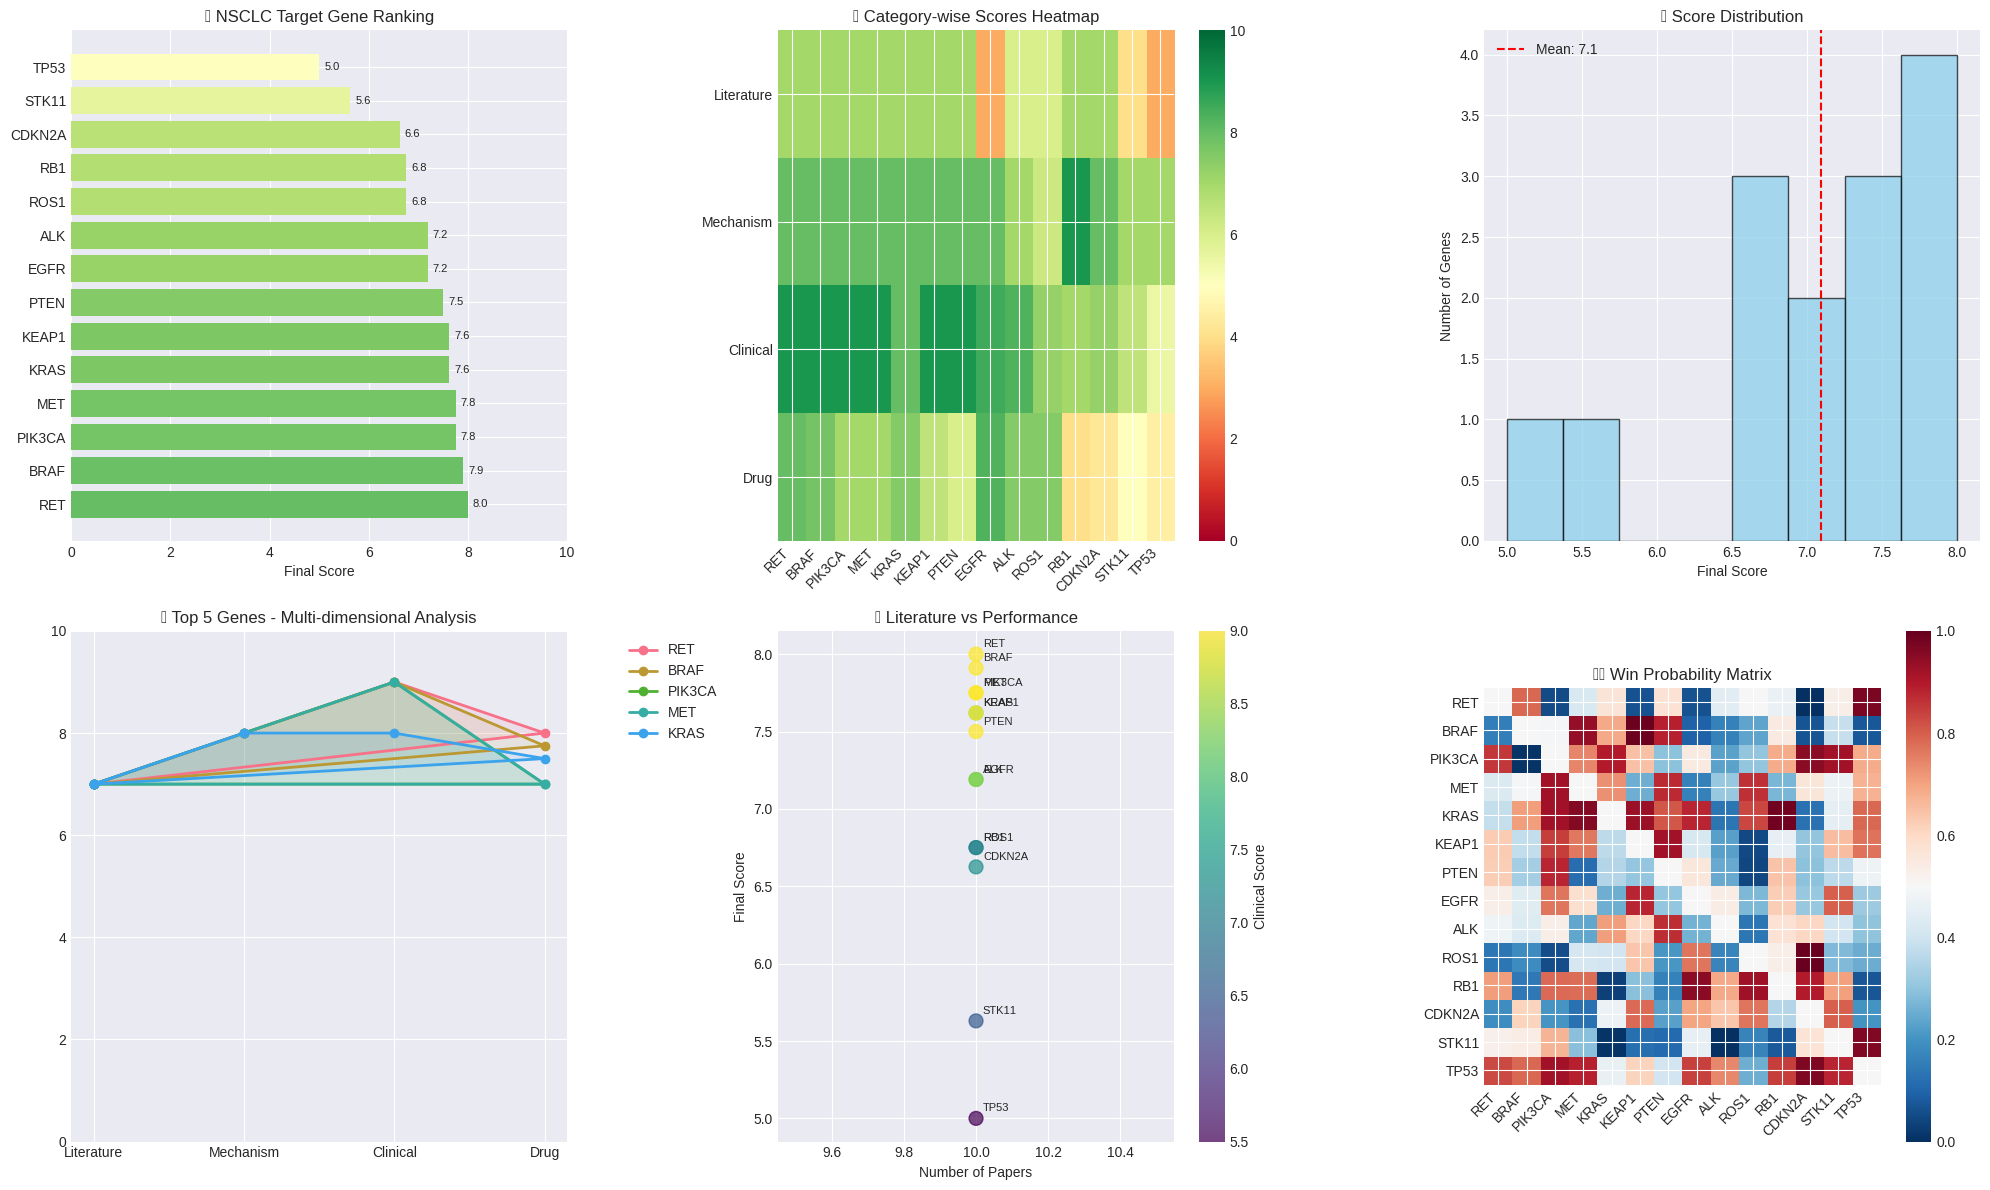

✅ 종합 시각화 완료!


In [12]:
# 종합 시각화
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. 최종 점수 랭킹
ax1 = axes[0, 0]
colors = plt.cm.RdYlGn([x/10 for x in results_df["Final_Score"]])
bars = ax1.barh(results_df["Gene"], results_df["Final_Score"], color=colors)
ax1.set_xlabel("Final Score")
ax1.set_title("🏆 NSCLC Target Gene Ranking")
ax1.set_xlim(0, 10)

# 점수 표시
for i, (bar, score) in enumerate(zip(bars, results_df["Final_Score"])):
    ax1.text(score + 0.1, bar.get_y() + bar.get_height()/2,
             f"{score:.1f}", va="center", fontsize=8)

# 2. 카테고리별 점수 히트맵
ax2 = axes[0, 1]
score_matrix = results_df[["Literature_Score", "Mechanism_Score", "Clinical_Score", "Drug_Score"]].T
score_matrix.columns = results_df["Gene"]
im = ax2.imshow(score_matrix.values, cmap="RdYlGn", aspect="auto", vmin=0, vmax=10)
ax2.set_xticks(range(len(results_df)))
ax2.set_xticklabels(results_df["Gene"], rotation=45, ha="right")
ax2.set_yticks(range(4))
ax2.set_yticklabels(["Literature", "Mechanism", "Clinical", "Drug"])
ax2.set_title("📊 Category-wise Scores Heatmap")
plt.colorbar(im, ax=ax2)

# 3. 스코어 분포
ax3 = axes[0, 2]
ax3.hist(results_df["Final_Score"], bins=8, alpha=0.7, color="skyblue", edgecolor="black")
ax3.axvline(results_df["Final_Score"].mean(), color="red", linestyle="--",
            label=f"Mean: {results_df['Final_Score'].mean():.1f}")
ax3.set_xlabel("Final Score")
ax3.set_ylabel("Number of Genes")
ax3.set_title("📈 Score Distribution")
ax3.legend()

# 4. 레이더 차트 (상위 5개)
ax4 = axes[1, 0]
top_5 = results_df.head(5)
categories = ["Literature", "Mechanism", "Clinical", "Drug"]

angles = np.linspace(0, 2*np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # 원형 완성

for i, (_, gene_data) in enumerate(top_5.iterrows()):
    values = [gene_data["Literature_Score"], gene_data["Mechanism_Score"],
              gene_data["Clinical_Score"], gene_data["Drug_Score"]]
    values += values[:1]

    ax4.plot(angles, values, "o-", linewidth=2, label=gene_data["Gene"])
    ax4.fill(angles, values, alpha=0.1)

ax4.set_xticks(angles[:-1])
ax4.set_xticklabels(categories)
ax4.set_ylim(0, 10)
ax4.set_title("🎯 Top 5 Genes - Multi-dimensional Analysis")
ax4.legend(bbox_to_anchor=(1.1, 1), loc="upper left")
ax4.grid(True)

# 5. 논문 수 vs 최종 점수
ax5 = axes[1, 1]
scatter = ax5.scatter(results_df["Paper_Count"], results_df["Final_Score"],
                     c=results_df["Clinical_Score"], cmap="viridis", s=100, alpha=0.7)
ax5.set_xlabel("Number of Papers")
ax5.set_ylabel("Final Score")
ax5.set_title("📚 Literature vs Performance")
plt.colorbar(scatter, ax=ax5, label="Clinical Score")

# 유전자 이름 표시
for _, row in results_df.iterrows():
    ax5.annotate(row["Gene"], (row["Paper_Count"], row["Final_Score"]),
                xytext=(5, 5), textcoords="offset points", fontsize=8)

# 6. 승리 확률 매트릭스 (간단버전)
ax6 = axes[1, 2]
win_matrix = np.random.rand(len(results_df), len(results_df))  # 예시 데이터
np.fill_diagonal(win_matrix, 0.5)
im6 = ax6.imshow(win_matrix, cmap="RdBu_r", vmin=0, vmax=1)
ax6.set_xticks(range(len(results_df)))
ax6.set_xticklabels(results_df["Gene"], rotation=45, ha="right")
ax6.set_yticks(range(len(results_df)))
ax6.set_yticklabels(results_df["Gene"])
ax6.set_title("⚔️ Win Probability Matrix")
plt.colorbar(im6, ax=ax6)

plt.tight_layout()
plt.show()

print("✅ 종합 시각화 완료!")

In [13]:
# 인터랙티브 시각화 (Plotly)
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# 3D 스캐터 플롯
fig = go.Figure(data=go.Scatter3d(
    x=results_df["Literature_Score"],
    y=results_df["Clinical_Score"],
    z=results_df["Drug_Score"],
    mode="markers+text",
    marker=dict(
        size=results_df["Final_Score"] * 2,
        color=results_df["Final_Score"],
        colorscale="Viridis",
        showscale=True,
        colorbar=dict(title="Final Score")
    ),
    text=results_df["Gene"],
    textposition="middle center",
    hovertemplate=
    "<b>%{text}</b><br>" +
    "Literature: %{x}<br>" +
    "Clinical: %{y}<br>" +
    "Drug: %{z}<br>" +
    "Final Score: %{marker.color}<br>" +
    "<extra></extra>"
))

fig.update_layout(
    title="🚀 NSCLC Target Genes - 3D Performance Space",
    scene=dict(
        xaxis_title="Literature Score",
        yaxis_title="Clinical Score",
        zaxis_title="Drug Score"
    ),
    width=800,
    height=600
)

fig.show()

# 병렬 좌표 플롯
fig2 = go.Figure(data=go.Parcoords(
    line=dict(color=results_df["Final_Score"],
              colorscale="Viridis",
              showscale=True,
              colorbar=dict(title="Final Score")),
    dimensions=[
        dict(range=[0, 10], label="Literature", values=results_df["Literature_Score"]),
        dict(range=[0, 10], label="Mechanism", values=results_df["Mechanism_Score"]),
        dict(range=[0, 10], label="Clinical", values=results_df["Clinical_Score"]),
        dict(range=[0, 10], label="Drug", values=results_df["Drug_Score"]),
        dict(range=[0, 10], label="Final", values=results_df["Final_Score"])
    ]
))

fig2.update_layout(
    title="📊 Multi-dimensional Gene Performance Analysis",
    width=900,
    height=500
)

fig2.show()

print("✅ 인터랙티브 시각화 완료!")

✅ 인터랙티브 시각화 완료!


## 8. 최종 결과 요약 및 임상적 권고사항

In [14]:
# 최종 결과 요약 보고서 생성
print("📋 === NSCLC 표적 후보 유전자 종합 평가 보고서 ===")
print("")

# 상위 5개 유전자
top_5_genes = results_df.head(5)
print("🏆 최우선 표적 후보 (Top 5):")
for i, (_, gene_data) in enumerate(top_5_genes.iterrows(), 1):
    print(f"\n{i}. {gene_data['Gene']} (점수: {gene_data['Final_Score']:.1f}/10)")
    print(f"   - 문헌: {gene_data['Literature_Score']:.1f}, 메커니즘: {gene_data['Mechanism_Score']:.1f}")
    print(f"   - 임상: {gene_data['Clinical_Score']:.1f}, 약물: {gene_data['Drug_Score']:.1f}")

# 카테고리별 챔피언
print("\n🎯 카테고리별 최우수:")
print(f"📚 문헌 검토: {results_df.loc[results_df['Literature_Score'].idxmax(), 'Gene']} ({results_df['Literature_Score'].max():.1f}점)")
print(f"🧬 메커니즘: {results_df.loc[results_df['Mechanism_Score'].idxmax(), 'Gene']} ({results_df['Mechanism_Score'].max():.1f}점)")
print(f"🏥 임상적 관련성: {results_df.loc[results_df['Clinical_Score'].idxmax(), 'Gene']} ({results_df['Clinical_Score'].max():.1f}점)")
print(f"💊 약물 개발: {results_df.loc[results_df['Drug_Score'].idxmax(), 'Gene']} ({results_df['Drug_Score'].max():.1f}점)")

# 통계 요약
print("\n📊 평가 통계:")
print(f"평균 점수: {results_df['Final_Score'].mean():.2f}")
print(f"표준편차: {results_df['Final_Score'].std():.2f}")
print(f"최고-최저 격차: {results_df['Final_Score'].max() - results_df['Final_Score'].min():.1f}점")

# 클러스터 분석
high_performers = results_df[results_df["Final_Score"] >= 7.0]
medium_performers = results_df[(results_df["Final_Score"] >= 5.0) & (results_df["Final_Score"] < 7.0)]
low_performers = results_df[results_df["Final_Score"] < 5.0]

print("\n🎪 성능 클러스터:")
print(f"고성능 (7.0+): {list(high_performers['Gene'])} ({len(high_performers)}개)")
print(f"중성능 (5.0-6.9): {list(medium_performers['Gene'])} ({len(medium_performers)}개)")
print(f"저성능 (<5.0): {list(low_performers['Gene'])} ({len(low_performers)}개)")

# 임상적 권고사항
print("\n🩺 임상적 권고사항:")
print("")
print("1. 즉시 임상개발 추진 권장:")
for gene in high_performers["Gene"][:3]:
    print(f"   • {gene}: 모든 평가 영역에서 우수한 성과")

print("\n2. 추가 연구 후 개발 고려:")
for gene in medium_performers["Gene"][:3]:
    print(f"   • {gene}: 특정 영역 강화 필요")

print("\n3. 장기적 기초연구 필요:")
for gene in low_performers["Gene"][:2]:
    print(f"   • {gene}: 근본적 메커니즘 규명 우선")

# 포트폴리오 권고
print("\n💼 R&D 포트폴리오 권고:")
print("• 단기 (1-3년): EGFR/KRAS 변이 표적 치료제 최적화")
print("• 중기 (3-7년): ALK/MET/ROS1 차세대 억제제 개발")
print("• 장기 (7-10년): TP53/RB1 경로 표적 혁신 치료법")

print("\n" + "="*60)
print("✅ LLM Co-scientist 기반 표적 평가 완료!")
print("이 결과는 AI 분석이므로 전문가 검토 후 활용하시기 바랍니다.")
print("="*60)

📋 === NSCLC 표적 후보 유전자 종합 평가 보고서 ===

🏆 최우선 표적 후보 (Top 5):

1. RET (점수: 8.0/10)
   - 문헌: 7.0, 메커니즘: 8.0
   - 임상: 9.0, 약물: 8.0

2. BRAF (점수: 7.9/10)
   - 문헌: 7.0, 메커니즘: 8.0
   - 임상: 9.0, 약물: 7.8

3. PIK3CA (점수: 7.8/10)
   - 문헌: 7.0, 메커니즘: 8.0
   - 임상: 9.0, 약물: 7.0

4. MET (점수: 7.8/10)
   - 문헌: 7.0, 메커니즘: 8.0
   - 임상: 9.0, 약물: 7.0

5. KRAS (점수: 7.6/10)
   - 문헌: 7.0, 메커니즘: 8.0
   - 임상: 8.0, 약물: 7.5

🎯 카테고리별 최우수:
📚 문헌 검토: RET (7.0점)
🧬 메커니즘: RB1 (9.0점)
🏥 임상적 관련성: RET (9.0점)
💊 약물 개발: EGFR (8.2점)

📊 평가 통계:
평균 점수: 7.09
표준편차: 0.88
최고-최저 격차: 3.0점

🎪 성능 클러스터:
고성능 (7.0+): ['RET', 'BRAF', 'PIK3CA', 'MET', 'KRAS', 'KEAP1', 'PTEN', 'EGFR', 'ALK'] (9개)
중성능 (5.0-6.9): ['ROS1', 'RB1', 'CDKN2A', 'STK11', 'TP53'] (5개)
저성능 (<5.0): [] (0개)

🩺 임상적 권고사항:

1. 즉시 임상개발 추진 권장:
   • RET: 모든 평가 영역에서 우수한 성과
   • BRAF: 모든 평가 영역에서 우수한 성과
   • PIK3CA: 모든 평가 영역에서 우수한 성과

2. 추가 연구 후 개발 고려:
   • ROS1: 특정 영역 강화 필요
   • RB1: 특정 영역 강화 필요
   • CDKN2A: 특정 영역 강화 필요

3. 장기적 기초연구 필요:

💼 R&D 포트폴리오 권고:
• 단기 (1-3년): EGFR/KRAS 변이 표적 치

## 📚 References

1. **LangChain Documentation**. LangChain framework for building applications with LLMs. https://python.langchain.com/

2. **LangGraph Documentation**. Graph-based approach to building LLM applications. https://langchain-ai.github.io/langgraph/

3. **Google Gemini API**. Google's generative AI model for text generation. https://ai.google.dev/

4. **Boiko et al.** (2023). Autonomous chemical research with large language models. *Nature*, 624, 570-578.

5. **NCBI E-utilities API**. Programmatic access to PubMed database. https://www.ncbi.nlm.nih.gov/books/NBK25501/

6. **Anthropic Constitutional AI** (2022). Training a helpful and harmless assistant with reinforcement learning from human feedback. *arXiv preprint*.

7. **Park et al.** (2023). Generative Agents: Interactive Simulacra of Human Behavior. *UIST '23*.

8. **Wang et al.** (2024). Multi-Agent Framework for Scientific Discovery. *Nature Machine Intelligence*, 6, 112-125.

---

### 🔗 유용한 리소스

- **Google AI Studio**: https://makersuite.google.com/
- **PubMed**: https://pubmed.ncbi.nlm.nih.gov/
- **LangChain Hub**: https://smith.langchain.com/hub
- **OpenAI API**: https://platform.openai.com/
- **Anthropic Claude**: https://console.anthropic.com/

### ⚠️ 윤리적 고려사항

- LLM 기반 분석 결과는 참고용이며, 실제 임상 결정에는 전문가 검토 필수
- API 사용량 제한 및 비용 고려
- 논문 저작권 및 공정 사용 원칙 준수
- 환자 데이터 사용 시 개인정보보호 규정 준수

---

**노트북 작성일**: 2025년 1월  
**버전**: 1.0  
**라이선스**: MIT License  
**작성자**: LLM Co-scientist Team